In [59]:
# What I am experimenting with here?
# I am using trying multiple pertubation to find what excites the most (Attribution)
# Averaging the multiple areas to find the specfic objects the NN is looking for
# Comparing that with the OOD Data 

# Based on Ruth C. Fong, Mandela Patrick and Andrea Vedaldi, Understanding Deep Networks via Extremal Perturbations and Smooth Masks, ICCV 2019

In [1]:
!pip install torchray

     |████████████████████████████████| 378kB 4.8MB/s 
  Created wheel for torchray: filename=torchray-1.0.0.2-cp36-none-any.whl size=444026 sha256=f1d7b5338ef4963e840850bbc7497dcc883d9532f74f2181c2b2cccfd6c0294b
  Stored in directory: /root/.cache/pip/wheels/49/21/6d/e6794f79658b66a0775b164fdd274b81a4c96e4eab5baaacb0
Successfully built torchray


In [2]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.benchmark import get_example_data, plot_example
from torchray.utils import get_device
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [3]:
transform=transforms.Compose([
            transforms.Resize((64,64)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

In [4]:

# Obtain example data.
model, x, category_id_1, category_id_2 = get_example_data()

data = torchvision.datasets.CIFAR10("/content/", train=True,transform=transforms.Compose([transforms.ToTensor()]) , download=True)

dataloader = DataLoader(data, batch_size=1,
                        shuffle=True, num_workers=0)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Extracting /content/cifar-10-python.tar.gz to /content/


In [5]:
trans = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64,64)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

trans_color = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64,64)),
            transforms.ToTensor()])

In [ ]:
results = []
device = get_device()
model.to(device)
area = 0.35

for x,y in tqdm(dataloader):
  x = x.to(device)
  if y.item() ==1:
    # Extremal perturbation
    masks_1,_ = extremal_perturbation(
        model, x, y.item(),
        reward_func=contrastive_reward,
        perturbation="blur",
        debug=False,
        areas=[area],
        smooth=0.01,
        max_iter=800
    )

    ## Crop Important Area
    dat=77torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
    true_points = np.argwhere(dat)
    if len(true_points) != 0:
      # take the smallest points and use them as the top left of your crop
      top_left = true_points.min(axis=0)
      # take the largest points and use them as the bottom right of your crop
      bottom_right = true_points.max(axis=0)
      x = trans_color(x.cpu().squeeze()).cpu().detach().numpy()
      out = x[:,top_left[1]:bottom_right[1], 
                top_left[2]:bottom_right[2]] 
      results.append(torch.tensor(out, dtype=torch.float))
     

In [67]:
color = []
for i in tqdm(range(len(results))):
  color.append(trans_color(results[i]).cpu().detach().numpy())
  results[i] = torch.flatten(trans(results[i]), start_dim=1).cpu().detach().numpy()

X1 = torch.flatten(torch.tensor(results), start_dim=1).cpu().detach().numpy()

X1.shape



# X_train = torch.flatten(result(torch.tensor(out[0])), start_dim=1).cpu().detach().numpy()
# print(len(X_train))


(55, 4096)

In [68]:
X = X1
X.shape

(55, 4096)

In [69]:
#Sanity check
print ("The shape of X is " + str(X.shape))

The shape of X is (55, 4096)


In [70]:
# To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
Clus_dataSet = StandardScaler().fit_transform(X) #(mean = 0 and variance = 1)

In [71]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.98 #The higher the explained variance the more accurate the model will remain
pca = PCA(variance)

In [72]:
#fit the data according to our PCA instance
pca.fit(Clus_dataSet)

PCA(copy=True, iterated_power='auto', n_components=0.98, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [73]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) #dimension reduced from 784

Number of components before PCA  = 4096
Number of components after PCA 0.98 = 24


In [74]:
#Transform our data according to our PCA instance
Clus_dataSet = pca.transform(Clus_dataSet)

In [75]:
print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape))

Dimension of our data after PCA  = (55, 24)


In [76]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(Clus_dataSet)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

Dimension of our data after inverse transforming the PCA  = (55, 4096)


In [88]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 6
ideal = None
max = float('-inf')
x = Clus_dataSet
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(5, kmax+1):
  kmeans = KMeans(init = "k-means++",n_clusters = k, n_init = 35).fit(x)
  labels = kmeans.labels_
  score = silhouette_score(x, labels, metric = 'euclidean')
  if(score > max):
    max = score
    ideal = kmeans

In [89]:
k_means = ideal
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=35, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [90]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1 2 3 4 5]


In [91]:
k_means_cluster_centers = k_means.cluster_centers_ #numpy array of cluster centers
k_means_cluster_centers.shape #comes from 10 clusters and 420 features

(6, 24)

In [92]:
k_means.labels_

array([4, 4, 0, 1, 2, 5, 5, 1, 4, 4, 1, 5, 2, 2, 3, 5, 1, 4, 4, 1, 2, 2,
       5, 0, 5, 4, 2, 3, 0, 4, 0, 4, 2, 4, 4, 2, 3, 3, 0, 0, 1, 2, 2, 3,
       0, 4, 0, 2, 1, 3, 0, 5, 4, 3, 0], dtype=int32)

In [93]:
#Find average "image" for each cluster
clusters = {}
for i,j in zip(k_means.labels_,color) :
  if i in clusters.keys():
    clusters.get(i).append(j)
    # clusters.update({i:clusters.get(i).append(j)})
  else:
    clusters.update({i:[j]})

In [94]:
print(clusters)

{4: [array([[[0.5529412 , 0.5529412 , 0.54901963, ..., 0.47058824,
         0.4627451 , 0.45882353],
        [0.5529412 , 0.5529412 , 0.54901963, ..., 0.47058824,
         0.4627451 , 0.45882353],
        [0.5529412 , 0.5529412 , 0.54901963, ..., 0.47058824,
         0.4627451 , 0.45882353],
        ...,
        [0.23529412, 0.23137255, 0.22745098, ..., 0.5176471 ,
         0.5372549 , 0.54509807],
        [0.24705882, 0.24313726, 0.23529412, ..., 0.4745098 ,
         0.49019608, 0.49411765],
        [0.2509804 , 0.24705882, 0.23921569, ..., 0.45490196,
         0.46666667, 0.47058824]],

       [[0.5176471 , 0.5137255 , 0.50980395, ..., 0.41568628,
         0.40392157, 0.4       ],
        [0.5176471 , 0.5137255 , 0.50980395, ..., 0.41568628,
         0.40392157, 0.4       ],
        [0.5176471 , 0.5137255 , 0.50980395, ..., 0.41568628,
         0.40784314, 0.40392157],
        ...,
        [0.23529412, 0.23529412, 0.23529412, ..., 0.4627451 ,
         0.49019608, 0.49803922],
       

In [95]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
def get_similar(arr):
  chosen = torch.tensor(arr[0])
  x = {}
  arr = arr[1:]
  for i in range(len(arr)):
    x.update({i: sum(sum(cos(torch.tensor(arr[i]),chosen))).item()})
  x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
  return (x.keys())
    


In [96]:
def choose_sim(arr,target,ratio):
  threshold = int(len(arr)*ratio)
  arr = arr[threshold:]
  result = []
  for i in range(len(target)):
    if(i in arr):
      result.append(target[i])
    
  return target

In [97]:
# Visualize results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


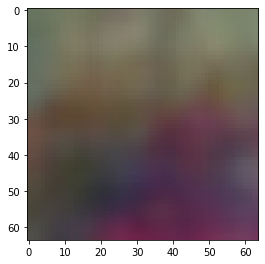

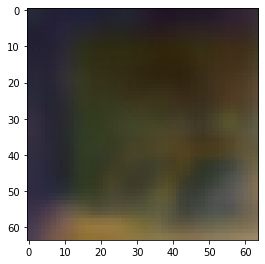

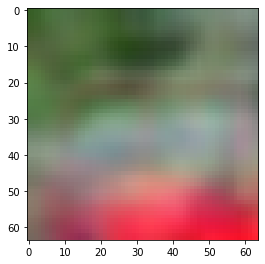

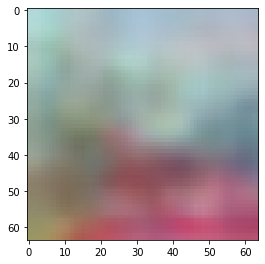

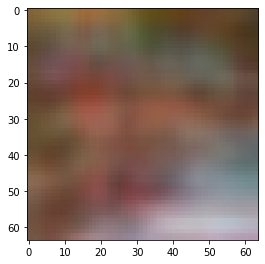

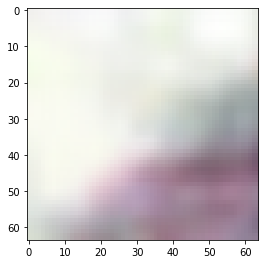

In [98]:
import matplotlib.pyplot as plt
from scipy import ndimage

i = 0
for key in clusters.keys():
  fig = plt.figure(figsize=(40,40))    
  ax = fig.add_subplot(8, 8, i + 1)
  arr = get_similar(clusters.get(key))
  arr = choose_sim(list(arr),clusters.get(key),1)
  arr = (sum(arr)/len(arr))
  img = np.asarray(torch.tensor(arr).cpu().squeeze().permute(1,2,0).detach().numpy() )
  filter_blurred_f = ndimage.gaussian_filter(img, 1)
  alpha = 2
  sharpened = img + alpha * (img - filter_blurred_f)

  ax.imshow(sharpened)
  i += 1
plt.show()
